In [1]:
# !pip install pandas
# !pip install numpy
# !pip install tensorflow
# !pip install keras-tuner
# !pip install matplotlib
# !pip install scikit-learn
# !pip install setuptools
# !pip install scipy
# !pip install pvlib
# !pip install ipython

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Conv1D, MaxPooling1D, Reshape, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from keras.losses import  MeanSquaredError, MeanAbsoluteError, MeanSquaredLogarithmicError
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
import matplotlib.pyplot as plt
import os

import pvlib

### Методи

In [3]:
# Довжину вхідної послідовності для LSTM
sequence_length = 1

# Кількість часових кроків на виході LSTM
forecast_steps = 1

In [4]:
# Представлення кодів погоди у вагових коефіцієнтах
def weather_codes(data):
    
    # Мапінг кодів у вагові коефіцієнти
    weather_code_mapping = {
        
        # Мінімальний вплив
        0: 0.2,

        # Середній вплив
        1: 0.5, 2: 0.5, 3: 0.5,
        51: 0.5, 53: 0.5, 55: 0.5,
        
        # Сильний вплив
        45: 0.8, 48: 0.8,
        56: 0.8, 57: 0.8,
        
        # Критичний вплив
        61: 1.0, 63: 1.0, 65: 1.0,
        66: 1.0, 67: 1.0,
        71: 1.0, 73: 1.0, 75: 1.0,
        77: 1.0,
        80: 1.0, 81: 1.0, 82: 1.0,
        85: 1.0, 86: 1.0,
        95: 1.0,
        96: 1.0, 99: 1.0
    }

    weather_code_column = 'weather_code'
    if weather_code_column in data.columns:
        data['weather_conditions'] = data[weather_code_column].map(weather_code_mapping)
        data.drop(columns=[weather_code_column], inplace=True)

    return data

In [5]:
def calculate_solarposition(_data, _latitude, _longitude, _altitude=350):

    # Отримуємо сонячну позицію для всіх рядків
    solar_positions = pvlib.solarposition.get_solarposition(
        time=_data.index,
        latitude=_latitude,
        longitude=_longitude,
        altitude=_altitude
    )
    # https://pvlib-python.readthedocs.io/en/v0.4.2/api.html
    
    _data['apparent_elevation'] = solar_positions['apparent_elevation'].clip(lower=0)
    _data['solar_azimuth'] = solar_positions['azimuth']
    _data['is_night'] = _data['apparent_elevation'] <= 0
    
    return _data

In [6]:
def get_forecast_0(_data, columns_list = ['gti', 'ghi', 'dni']):

    # Перевірка на порожній DataFrame
    if _data.empty:
        print("Вхідний DataFrame _data порожній.")
        return _data
    
    # Вибірка даних
    columns = [col for col in columns_list if col in _data.columns]
    
    if not columns:
        print("Жодна з колонок у columns_list не знайдена в _data.")
        return _data
    
    X = _data[columns]
    if X.empty:
        print("Відфільтрований DataFrame X порожній.")
        return _data
    
    if 'power' not in _data.columns:
        print("Колонка 'power' відсутня в _data.")
        return _data
    
    y = _data['power']

    reg = LinearRegression()
    reg.fit(X, y)

    # Прогнозування
    y_pred = reg.predict(X)
    _data['forecast_0'] = y_pred
    _data.loc[:, 'forecast_0'] = _data['forecast_0'].clip(lower=0)

    return _data

In [7]:
# Cинусоїдальні та косинусоїдальні перетворення часу для моделювання циклічності часу (доба і рік)
def time_transform(_data, _tranform_hours = True, _transform_days = True):

    # Трансформація годин
    if _tranform_hours:
        _data["minute"] = _data["datetime"].dt.minute
        _data["hour"] = _data["datetime"].dt.hour
        _data["total_minutes"] = _data["hour"] * 60 + _data["minute"]
    
        peak_shift = 780 + 3 * 60
        _data["adjusted_minutes"] = (
            _data["total_minutes"] - peak_shift) % 1440

        # Застосування синусоїдальних і косинусоїдальних перетворень до годин
        _data["hour_sin"] = np.sin(
            2 * np.pi * _data["adjusted_minutes"] / 1440)
        _data["hour_cos"] = np.cos(
            2 * np.pi * _data["adjusted_minutes"] / 1440)
        
        _data.drop(columns=["minute","hour","total_minutes","adjusted_minutes"],errors="ignore",inplace=True,)

    # Трансформація дня року
    if _transform_days:
        _data["day"] = _data["datetime"].dt.dayofyear
        peak_shift_day = 173

        _data["adjusted_day"] = (_data["day"] - peak_shift_day) % 365

        # Застосування синусоїдальних і косинусоїдальних перетворень до днів року
        _data["day_sin"] = np.sin(2 * np.pi * _data["adjusted_day"] / 365)
        _data['day_cos'] = np.cos(
            2 * np.pi * _data['adjusted_day'] / 365 / 2.)

        _data.drop(columns=["day","adjusted_day",],errors="ignore",inplace=True,)

In [8]:
# Отримання даних по станції за період
def get_data(_station_name, _power_max, _date_start, _date_end, _meteo_source = 'OpenMeteo', _actual_source = 'Nordik'):

    # Завантаження даних
    df_meteo = pd.read_csv(f'../data/{_station_name}_{_meteo_source}_Data.csv', sep=',', comment='#')
    df_meteo['datetime'] = pd.to_datetime(df_meteo['datetime'], format='mixed', utc=True)

    actual_parameters=['datetime', 'power', 'limitation']
    df_actual = pd.read_csv(f'../data/{_station_name}_{_actual_source}_Data.csv', sep=',', comment='#', usecols=actual_parameters)
    df_actual['datetime'] = pd.to_datetime(df_actual['datetime'], format='mixed', utc=True)

    # Злиття датафреймів
    data_input = pd.DataFrame()
    data_input = pd.merge(df_actual, df_meteo, on='datetime', how='outer', suffixes=('_actual', '_predict'))

    # Перевірка на однакові колонки
    for col in df_actual.columns:
        if col in df_meteo.columns and col not in ['datetime']:
            # Якщо є однакові колонки то залишити з df_actual 
            data_input[col] = data_input[f"{col}_actual"].combine_first(data_input[f"{col}_predict"])
            data_input.drop(columns=[f"{col}_predict", f"{col}_actual"], inplace=True)

    # Збереження необхідних колонок
    data_input.columns = [col.replace('_actual', '') for col in data_input.columns]
    data_input = data_input[df_actual.columns.tolist() + [col for col in df_meteo.columns if col not in df_actual.columns and col != 'datetime']]

    time_transform(data_input, _tranform_hours = True, _transform_days = True)
    data_input.set_index('datetime', inplace=True)

    # Фільтрація даних за датою
    if _date_start is not None and _date_end is not None:
        _data = data_input.loc[_date_start:_date_end].copy()
    elif _date_start is not None:
        _data = data_input.loc[_date_start:].copy()
    elif _date_end is not None:
        _data = data_input.loc[:_date_end].copy()
    else:
        _data = data_input.copy()

    # Видалення невалідних записів
    if 'limitation' in _data.columns:
        _data = _data[_data['limitation'] == 0]
        _data.drop(columns=['limitation'], inplace=True)
    
    # Видалення пропущених значень
    _data.dropna(inplace=True)
    
    # Обмеження значень потужності
    _data.clip(lower=0, upper=_power_max, inplace=True)

    return _data

In [9]:
# Додавання лагів для вибраних ознак
def add_lag_features(_data, lagged_features, lags):
    
    new_features = lagged_features.copy()

    for feature in lagged_features:
        for lag in range(1, lags + 1):
            lag_col = f'{feature}_lag_{lag}'
            _data[lag_col] = _data[feature].shift(lag)
            new_features.append(lag_col)

    # Видалення рядків з порожніми значеннями після додавання лагів
    _data.dropna(subset=new_features, inplace=True)
    return _data

In [10]:
# Додаткові ознаки
def add_features(_data, _latitude, _longitude, _altitude, _meteo_source='OpenMeteo'):

    # Розрахунок висоти сонця
    calculate_solarposition(_data, _latitude, _longitude, _altitude)

    # Обробка кодів погоди
    weather_codes(_data)

    # Розрахунок прогнозної потужності Linear Regression
    meteo_parameters_dict = {
        # 'Copernicus': ['toa', 'ghi', 'bhi', 'dhi', 'bni'],
        'OpenMeteo': ['gti', 'ghi', 'dni'],
    }
    meteo_parameters = meteo_parameters_dict.get(_meteo_source, ['ghi'])
    get_forecast_0(_data,
                   columns_list=meteo_parameters)

    add_lag_features(_data, ['ghi', 'forecast_0'], 3)

    return _data


In [11]:
# Підготовка даних для моделі
def prepare_data(_data, _scaler, _power_max, _split_ratio=0.8, use_all_features = False):

    # Вибрані ознаки
    if use_all_features:
        feature_columns = [col for col in _data.columns if col != "power"]
    else:
        feature_columns = ['forecast_0', 'ghi', 'temperature_air', 'humidity', 'apparent_elevation', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
        feature_columns += [col for col in _data.columns if '_lag_' in col]

    # Цільова змінна
    target_column = 'power'    

    # Вибірка даних для моделі
    # Перша колонка - цільова змінна power, інші - ознаки
    _data = _data[[target_column] + feature_columns]

    # Розділення даних на навчальну та тестову вибірки
    if _split_ratio != 0:
        split_index = int(len(_data) * _split_ratio)
        data_train = _data.iloc[:split_index]
        data_test = _data.iloc[split_index:]
    else:
        data_train = _data
        data_test = _data

    # Масштабування даних
    data_train_scaled = _scaler.fit_transform(data_train)
    data_test_scaled = _scaler.transform(data_test)

    def prepare_sequences(scaled_data, original_data, sequence_length, forecast_steps):
        X, y, datetimes = [], [], []
        for i in range(sequence_length, len(scaled_data) - forecast_steps + 1):
            y.append(scaled_data[i:i+forecast_steps, 0])    # цільова змінна power
            X.append(scaled_data[i-sequence_length:i, 1:])  # ознаки
            datetimes.append(original_data.index[i+forecast_steps-1])
        return np.array(X), np.array(y), datetimes

    X_train, y_train, datetimes_train = prepare_sequences(data_train_scaled, data_train, sequence_length, forecast_steps)

    X_test, y_test, datetimes_test = prepare_sequences(data_test_scaled, data_test, sequence_length, forecast_steps)

    print(f"Розмір навчальної вибірки: {len(X_train)}")
    print(f"Розмір тестової вибірки: {len(X_test)}")
    print(f"Ознаки ({len(feature_columns)}): {feature_columns}")

    return X_train, X_test, y_train, y_test, datetimes_train, datetimes_test

In [12]:
def restore_data(_scaler, _forecast, _X_test, _y_test, _datetimes_test):
    
    # Визначення кількості колонок у початкових масштабованих даних
    n_features = _scaler.n_features_in_

    # Відновлення масштабу для тестових даних
    y_test_rescaled = _scaler.inverse_transform(
        np.c_[_y_test[:, 0], np.zeros((_y_test.shape[0], n_features - 1))]
    )[:, 0]

    # Відновлення масштабу для прогнозу
    forecast_rescaled = _scaler.inverse_transform(
        np.c_[_forecast[:, 0], np.zeros((_forecast.shape[0], n_features - 1))]
    )[:, 0]

    # Створення DataFrame з відновленими даними
    data_forecast = pd.DataFrame({
        "datetime": _datetimes_test,
        "power": y_test_rescaled,
        "forecast": forecast_rescaled
    })

    data_forecast.sort_values('datetime', inplace=True)

    return data_forecast

In [13]:
def correct_forecast(_data_forecast, _data):
    
    _data_forecast.loc[:, 'forecast'] = _data_forecast['forecast'].clip(lower=0)

    _data_forecast = _data_forecast.merge(_data, on='datetime', how='left', suffixes=('', '_train'))

    if 'forecast_0' in _data_forecast.columns:
        _data_forecast.loc[(_data_forecast['forecast_0'] == 0) | (_data_forecast['is_night'] == 1), 'forecast'] = 0

    return _data_forecast

In [14]:
# Відображення кривих навчання
def plot_loss(_history, _title='Криві навчання', _metrics=['loss']):

    for metric in _metrics:
        plt.figure(figsize=(5, 3))
        plt.plot(_history.history[metric], label=f'{metric} на тренуванні')
        plt.plot(_history.history[f'val_{metric}'], label=f'{metric} на перевірці')
        plt.xlabel('епохи')
        plt.ylabel(metric)
        plt.title(f'{_title} - {metric}')
        plt.legend()
        plt.grid(True)
        plt.show()

In [15]:
# Відображення часових рядів
def plot_series(_data, _columns, _title="Фактична і Прогнозована потужність", _metrics=None, _split_days = 6):

    # Дата-час може бути в індексі або в колонці "datetime"
    if "datetime" in _data.columns:
        datetime_col = _data["datetime"]
    else:
        datetime_col = _data.index

    start_index = 0
    end_index = len(_data)
    data_plot = _data.iloc[start_index:end_index].copy()
    datetime_col_plot = datetime_col[start_index:end_index]

    # Візуалізація графіків
    plt.figure(figsize=(15, 5))
    for col in _columns:
        plt.plot(datetime_col_plot, data_plot[col["column"]], label=col["label"])
    plt.title(f"{_title}")
    
    # Візуалізація метрик
    metrics_text = ""
    if _metrics is not None:
        metrics_text = f'TAE = {_metrics["TAE"]:.1f}\nMAE = {_metrics["MAE"]:.1f}\nMAPE (max) = {_metrics["MAPE(max)"]:.1f}%\nMSE = {_metrics["MSE"]:.1f}\nRMSE(max) = {_metrics["RMSE(max)"]:.2f}%\nMSLE = {_metrics["MSLE"]:.4f}\nR² = {_metrics["R2"]:.4f}\nBias = {_metrics["Bias"]:.2f}%\n\nAPE(filtered) = {_metrics["APE(filtered)"]:.2f}%\n'
    plt.legend(loc='upper left', title=metrics_text)
    
    plt.grid(True)
    plt.show()

    # Візуалізація графіків по частинах
    data_len = len(_data)
    days_in_step = _split_days * 24 * 4
    for i in range(0, data_len, days_in_step):
        data_chunk = _data.iloc[i:i + days_in_step]
        datetime_chunk = datetime_col.iloc[i:i + days_in_step]

        plt.figure(figsize=(15, 5))
        for col in _columns:
            plt.plot(datetime_chunk, data_chunk[col["column"]], label=col["label"])
        plt.title(f"{_title} - Інтервал {i // days_in_step + 1}")
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()


In [16]:
# Завантаження моделі з файлу
def get_model(_model_name):
    
    model = load_model(f"../temp/{_model_name}.keras")
    scaler = np.load(f"../temp/{_model_name}.npy", allow_pickle=True).item()
    
    return model, scaler

In [17]:
# Побудова моделі
def create_model(X_train):

    # Побудова моделі
    layer_params = [
        {
            "units": 128,
            "activation": "relu",
            "dropout": 0.01,
            "regularizer": l2(0.01)
        },
        {
            "units": 256,
            "activation": "relu",
            "dropout": 0.01,
            "regularizer": l2(0.01)
        },
        {
            "units": 128,
            "activation": "relu",
            "dropout": 0.01,
            "regularizer": l2(0.01)
        },
    ]
    model_lstm = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(
            units=layer_params[0]["units"],
            activation=layer_params[0]["activation"],
            return_sequences=True,
            kernel_regularizer=layer_params[0]["regularizer"],
        ),
        Dropout(layer_params[0]["dropout"]),
        BatchNormalization(),
        LSTM(
            units=layer_params[1]["units"],
            activation=layer_params[1]["activation"],
            return_sequences=True,
            kernel_regularizer=layer_params[1]["regularizer"],
        ),
        Dropout(layer_params[1]["dropout"]),
        BatchNormalization(),
        LSTM(
            units=layer_params[2]["units"],
            activation=layer_params[2]["activation"],
            return_sequences=True,
            kernel_regularizer=layer_params[2]["regularizer"],
        ),
        Dropout(layer_params[2]["dropout"]),
        BatchNormalization(), 
        LSTM(50, return_sequences=False),
        Dense(forecast_steps)
    ])
    # Компіляція моделі
    model_lstm.compile(optimizer='nadam', loss=[MeanSquaredError(), MeanSquaredLogarithmicError()])
    # MeanSquaredLogarithmicError, MeanSquaredError, MeanAbsoluteError

    return model_lstm

    # Проста модель
    # model_lstm = Sequential([
    #     Input(shape=(X_train.shape[1], X_train.shape[2])),
    #     LSTM(50, return_sequences=False),
    #     Dense(forecast_steps)
    # ])
    # # Компіляція моделі
    # model_lstm.compile(optimizer='adam', loss='mse')    
    # return model_lstm

In [18]:
# Збереження моделі в файлі
def save_model(_model, _scaler, _model_name):

    os.makedirs("../temp", exist_ok=True)
    
    _model.save(f"../temp/{_model_name}.keras")
    np.save(f"../temp/{_model_name}.npy", _scaler)

In [19]:
# Тренування моделі
def do_train(_model, _X_train, _X_test, y_train, y_test):

    history = _model.fit(
        _X_train, y_train,
        validation_data=(_X_test, y_test),
        epochs=32,
        batch_size=64,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1
    )
    return history

In [20]:
# Розрахунок метрик
def do_eval(_forecast, _actual, _power_max, _print_metrics=False):
        
        epsilon = 1e-8
        _actual = np.where(_actual == 0, epsilon, _actual)

        tae = np.sum(np.abs(_forecast - _actual))    
        mae = mean_absolute_error(_actual, _forecast)

        mape_max = np.mean(np.abs((_forecast - _actual) / _power_max)) * 100    
        mse = mean_squared_error(_actual, _forecast)
        rmse_max = np.sqrt(mse) / _power_max * 100
        r2 = r2_score(_actual, _forecast)
        bias = np.mean(_forecast - _actual) / _power_max * 100

        ape_koef = 0.1
        mask = _actual > ape_koef * _power_max
        if np.any(mask):
            ape_filtered = np.mean(np.abs((_forecast[mask] - _actual[mask]) / _actual[mask])) * 100
        else:
            ape_filtered = np.nan
        
        msle = mean_squared_log_error(_actual - np.min(_actual) + 1,
                                      _forecast - np.min(_forecast) + 1)

        if _print_metrics:
            print(f"TAE: {tae}")
            print(f"MAE: {mae}")
            print(f"MAPE(max): {mape_max} %")
            print(f"MSE: {mse}")
            print(f"RMSE(max): {rmse_max} %")
            print(f"R²: {r2}")
            print(f"Bias: {bias} %")
            print(f"APE ({ape_koef}): {ape_filtered}")
            print(f"MSLE: {msle}")

        return {
            "TAE": tae,
            "MAE": mae,
            "MAPE(max)": mape_max,
            "MSE": mse,
            "RMSE(max)": rmse_max,
            "R2": r2,
            "Bias": bias,
            "APE(filtered)": ape_filtered,
            "MSLE": msle
        }

In [21]:
# Прогнозування
def do_forecast(_model, _X_test):

    forecast = _model.predict(_X_test)
    return forecast

## Навчання та прогнозування

In [22]:
model_name = 'lstm_openmeteo'

train_info = [
    {
        "station_name": 'Yavoriv',
        "meteo_source": 'OpenMeteo',
        "power_max": 59234,
        "latitude": 49.935239,
        "longitude": 23.505527,
        "altitude": 270,
        "date_train_start": '2024-04-02',
        "date_train_end": '2024-09-30'
    },
]

# +----------------------------------------------------+--------------+
# |                   Навчання                         |   Прогноз    |
# +----------------------------------------------------+--------------+
# 2024-04-01                                     2024-08-27     2024-09-30




============= Yavoriv 2024-04-02 - 2024-09-30 =============
TAE: 56950309.30871877
MAE: 3375.2331718555547
MAPE(max): 5.698134807467933 %
MSE: 42752778.41765456
RMSE(max): 11.038526661659333 %
R²: 0.8754553107304259
Bias: 0.04904112854753526 %
APE (0.1): 31.99576913645125
MSLE: 0.7908043553696432
Розмір навчальної вибірки: 13497
Розмір тестової вибірки: 3374
Ознаки (30): ['cloud_cover_high', 'cloud_cover_low', 'cloud_cover_mid', 'dew_point', 'dni', 'ghi', 'gti', 'humidity', 'pressure_air', 'sunshine', 'temperature_air', 'temperature_soil', 'visibility', 'wind_direction', 'wind_speed', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'apparent_elevation', 'solar_azimuth', 'is_night', 'weather_conditions', 'forecast_0', 'ghi_lag_1', 'ghi_lag_2', 'ghi_lag_3', 'forecast_0_lag_1', 'forecast_0_lag_2', 'forecast_0_lag_3']
Epoch 1/32
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2.5420 - mean_squared_error_loss: 0.0000e+00 - mean_squared_logarithmic_error_loss: 0.0000e+00 - val_loss: 0.1307 

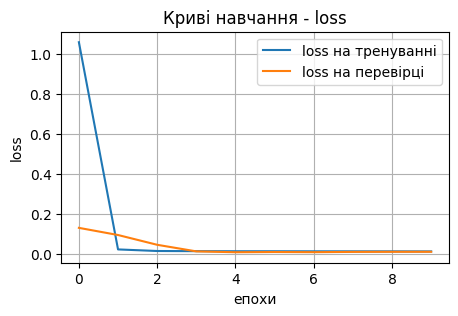

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
TAE: 8026542.217883314
MAE: 2378.9396022179353
MAPE(max): 4.016172472259067 %
MSE: 26541679.21047353
RMSE(max): 8.697473955436557 %
R²: 0.9189930982256163
Bias: -1.553650101951612 %
APE (0.1): 25.050712137704885
MSLE: 0.5500137941489296


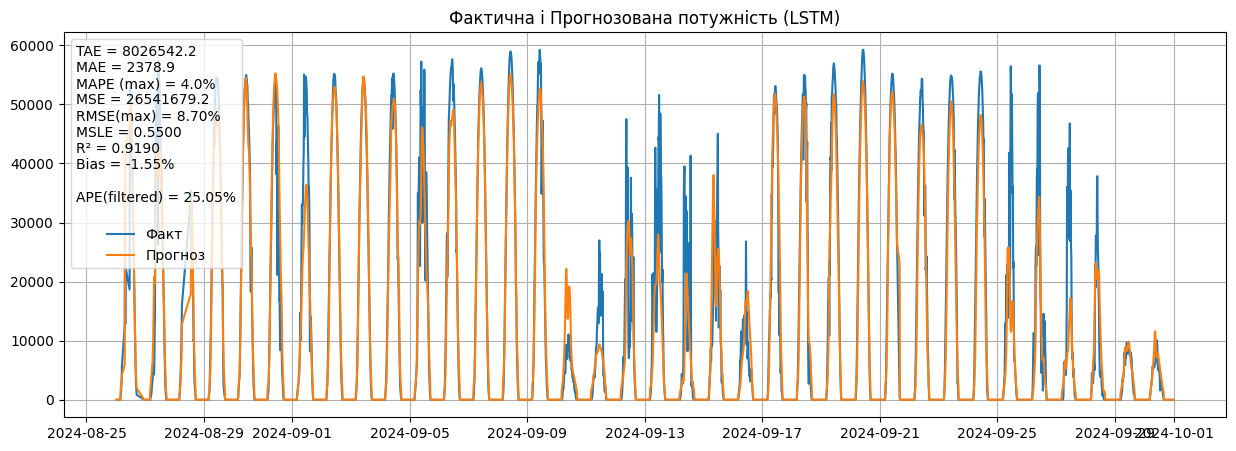

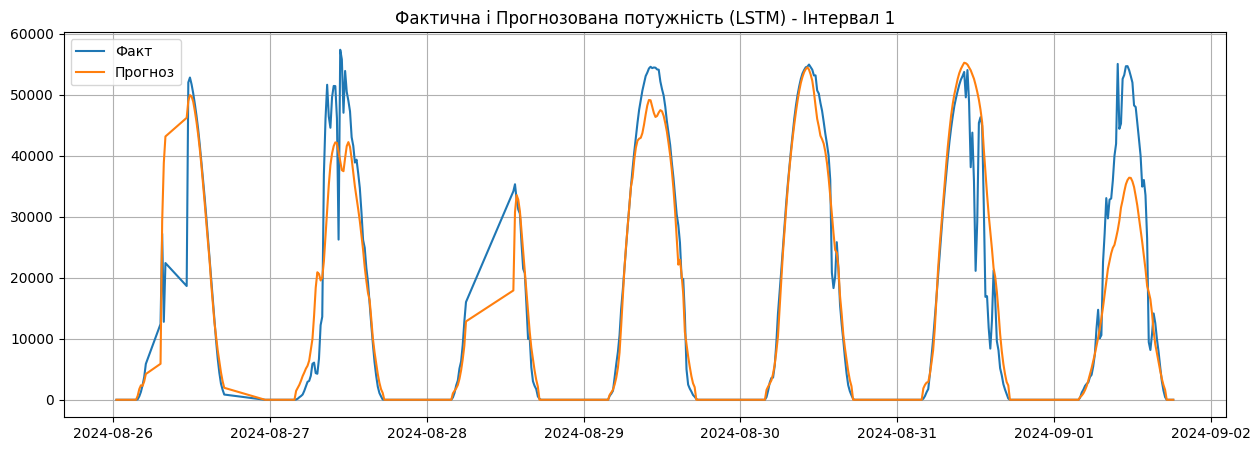

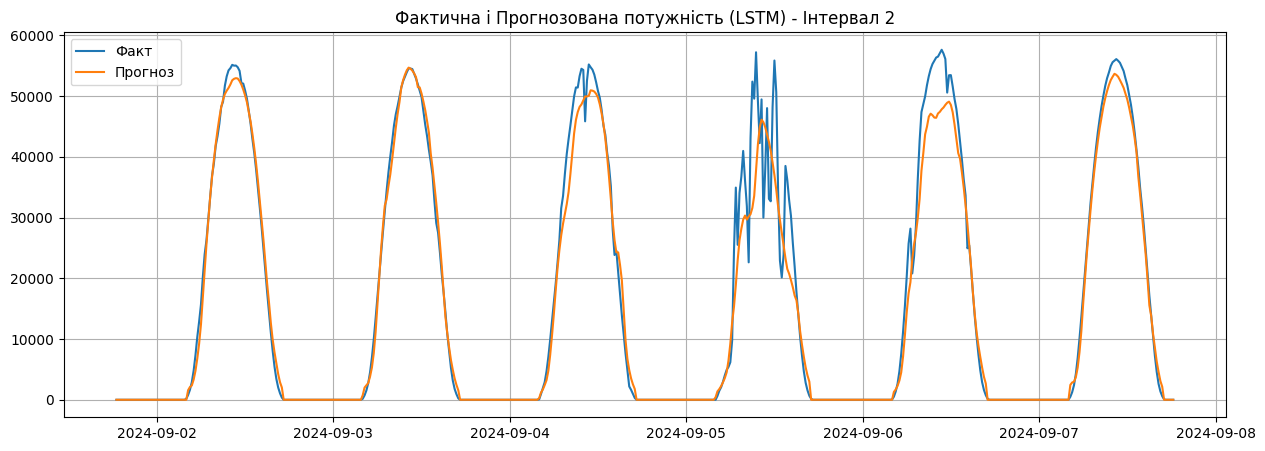

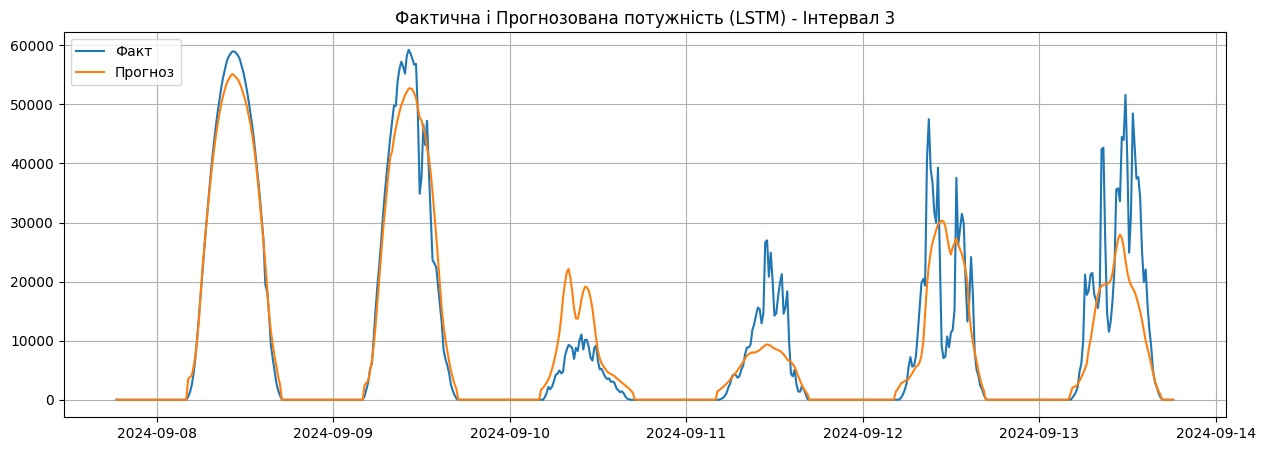

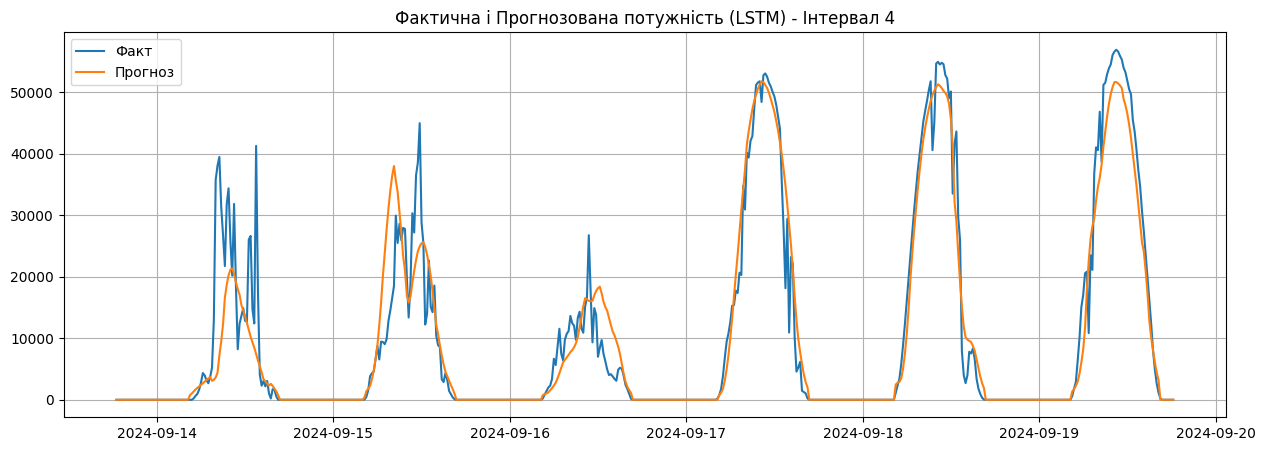

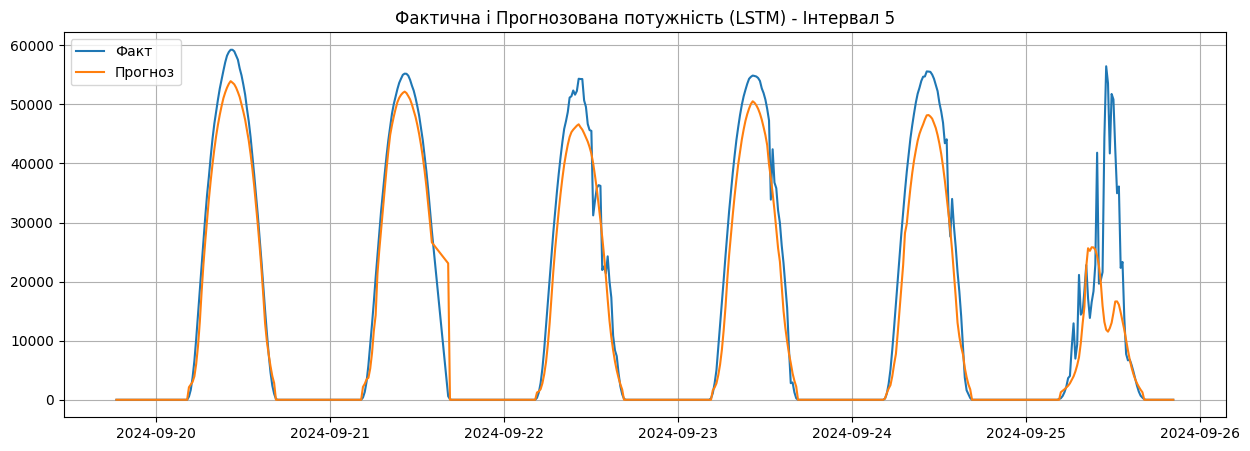

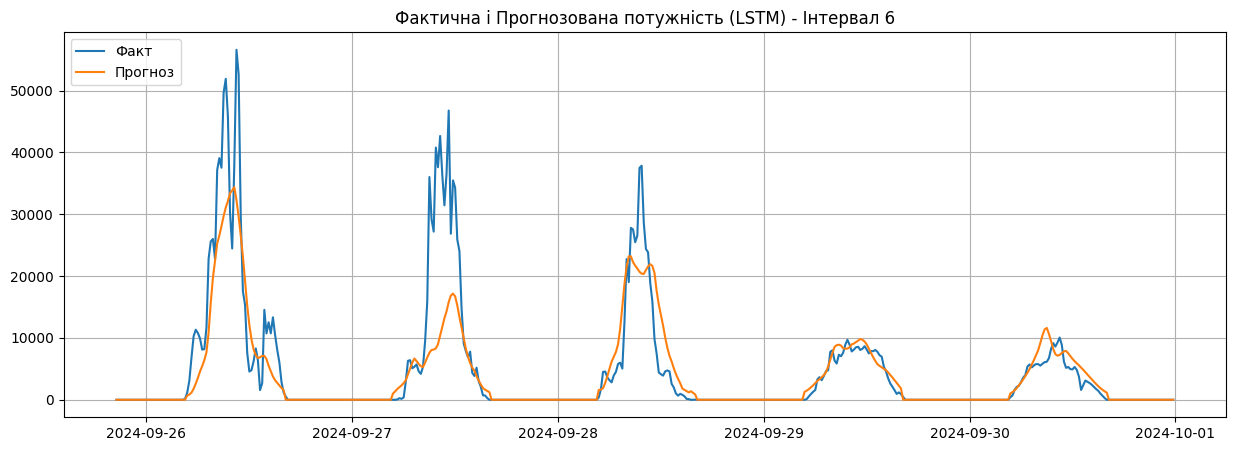

In [23]:
# Завантаження даних
info = train_info[0]
data = get_data(
        _station_name=info["station_name"],
        _power_max=info["power_max"],
        _date_start=info["date_train_start"],
        _date_end=info["date_train_end"],
        _meteo_source=info["meteo_source"]
        )
power_max = info["power_max"]

print(f"\n\n============= {info['station_name']} {info['date_train_start']} - {info['date_train_end']} =============")

# Додавання ознак
add_features(data,
             info["latitude"], info["longitude"], info["altitude"],
             _meteo_source=info["meteo_source"]
            )
do_eval(_forecast=data['forecast_0'], _actual=data['power'], _power_max=power_max, _print_metrics=True)
# print(data)

# Підготовка даних
scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test, y_train, y_test, datetimes_train, datetimes_test = prepare_data(_data=data,
                                                                                 _scaler=scaler,
                                                                                 _power_max=power_max,
                                                                                 _split_ratio=0.8,
                                                                                 use_all_features = True)

model = create_model(X_train)

# Тренування моделі
history_train = do_train(model, X_train, X_test, y_train, y_test)
plot_loss(_history=history_train, _title='Криві навчання', _metrics=['loss'])

# Збереження моделі
save_model(model, scaler, model_name)

# Прогнозування
forecast = do_forecast(model, X_test)

# Відновлення даних та корекція прогнозу
_data_forecast = restore_data(_scaler=scaler, _forecast=forecast, _X_test=X_test, _y_test=y_test, _datetimes_test=datetimes_test)
_data_forecast = correct_forecast(_data_forecast, data)

# 
metrics = do_eval(_forecast=_data_forecast['forecast'], _actual=_data_forecast['power'], _power_max=power_max, _print_metrics=False)

# Оцінка прогнозу і візуалізація часовових рядів потужності
plot_series(_data=_data_forecast,
            _columns=  [{"column": "power", "label": "Факт", "power_max": info["power_max"]},
                        {"column": "forecast", "label": "Прогноз", "power_max": info["power_max"]}],
            _title="Фактична і Прогнозована потужність (LSTM)",
            _metrics=do_eval(_forecast=_data_forecast['forecast'], _actual=_data_forecast['power'], _power_max=power_max, _print_metrics=True),
            )